# Проект: Анализ вакансий из HeadHunter

Изучаем данные о вакансиях с сайта HeadHunter.

## Цели работы

Сложить по возможности полное представление о вакансиях в имеющемся наборе данных. Сделать неочевидные выводы.

## Этапы работы

- Знакомство с данными;
- Предварительный анализ данных;
- Детальный анализ вакансий;
- Анализ работодателей;
- Предметный анализ.

## О данных

Данные берём с удалённого сервера. Подключение происходит по логину и паролю. Извлекаем данные с помощью SQL запросов.

Взаимосвязь таблиц отражена в схеме:

![](img/SQL_pj2_2_1_scheme.png)

VACANCIES

Таблица хранит в себе данные по вакансиям и содержит следующие столбцы:

![](img/SQL_pj2_2_2_vacancies.png)

Зарплатная вилка — это верхняя и нижняя граница оплаты труда в рублях (зарплаты в других валютах уже переведены в рубли). Соискателям она показывает, в каком диапазоне компания готова платить сотруднику на этой должности.

AREAS

Таблица-справочник, которая хранит код города и его название.

![](img/SQL_pj2_2_3_areas.png)

EMPLOYERS

Таблица-справочник со списком работодателей.

![](img/SQL_pj2_2_4_employers.png)

INDUSTRIES

Таблица-справочник вариантов сфер деятельности работодателей.

![](img/SQL_pj2_2_5_industries.png)

EMPLOYERS_INDUSTRIES

Дополнительная таблица, которая существует для организации связи между работодателями и сферами их деятельности.

Эта таблица нужна нам, поскольку у одного работодателя может быть несколько сфер деятельности (или работодатели могут вовсе не указать их). Для удобства анализа необходимо хранить запись по каждой сфере каждого работодателя в отдельной строке таблицы.

![](img/SQL_pj2_2_2_vacancies.pngSQL_pj2_2_6_employers_industries.png)



In [1]:
#!pip install psycopg2

In [59]:
#Импортируем нужные библиотеки
import pandas as pd
import psycopg2
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

In [3]:
#Данные для подключения к базе 
DBNAME = 'project_sql'
USER = 'skillfactory'
PASSWORD = 'cCkxxLVrDE8EbvjueeMedPKt'
HOST = '84.201.134.129'
PORT = 5432

In [4]:
#Создаём подключение
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

## Предварительный анализ данных

Оценим общее количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [51]:
# текст запроса
query_3_1 = f'''
            SELECT COUNT(*) AS vacancies_count
            FROM public.vacancies
'''

In [52]:
# используем метод read_sql_query, чтобы получить результаты запроса сразу в виде датафрейма
vac_count = pd.read_sql_query(query_3_1, connection)
print(f'Количество вакансий в базе: {vac_count.vacancies_count[0]}')

Количество вакансий в базе: 49197


Посчитаем количество работодателей (таблица employers). 

In [53]:
# текст запроса
query_3_2 = f'''
            SELECT COUNT(*) AS employers_count
            FROM public.employers
'''

In [54]:
# результат запроса
emp_count = pd.read_sql_query(query_3_2, connection)
print(f'Количество работодателей: {emp_count.employers_count[0]}')

Количество работодателей: 23501


Посчитаем количество регионов, представленных в данных (таблица areas).

In [55]:
# текст запроса
query_3_3 = f'''
            SELECT COUNT(*) AS areas_count
            FROM public.areas
'''

In [56]:
# результат запроса
areas_count = pd.read_sql_query(query_3_3, connection)
print(f'Количество регионов: {areas_count.areas_count[0]}')

Количество регионов: 1362


Посчитаем количество сфер деятельности в базе (таблица industries).

In [57]:
# текст запроса
query_3_4 = f'''
            SELECT COUNT(*) AS industries_count
            FROM public.industries
'''

In [58]:
# результат запроса
ind_count = pd.read_sql_query(query_3_4, connection)
print(f'Количество сфер деятельности: {ind_count.industries_count[0]}')

Количество сфер деятельности: 294


### Выводы по предварительному анализу данных

- Данные включают 5 таблиц: vacancies, employers, areas, employers_industries, industries.

- Общее количество вакансий в таблице vacancies - 49197

- Общее количество работотаделей в таблице employers - 23501

- Количество регионов, представленных в таблице areas - 1362

- Количество сфер деятельности, представленных в таблице industries - 294

## Детальный анализ вакансий

Определим, сколько (cnt) вакансий в каждом регионе (area).
Отсортируем по количеству вакансий в порядке убывания.

Выведем пятёрку регионов-лидеров по количествю вакансий.

In [13]:
# текст запроса
query_4_1 = f'''
            SELECT COUNT(vac.name) AS vacancy_count, 
                   ar.name AS region_name
            FROM public.vacancies AS vac
            JOIN public.areas AS ar
            ON vac.area_id=ar.id
            GROUP BY region_name
            ORDER BY vacancy_count desc
            LIMIT 5
'''

In [14]:
# результат запроса
vac_by_areaid_count = pd.read_sql_query(query_4_1, connection)
vac_by_areaid_count


,vacancy_count,region_name
0,5333,Москва
1,2851,Санкт-Петербург
2,2112,Минск
3,2006,Новосибирск
4,1892,Алматы


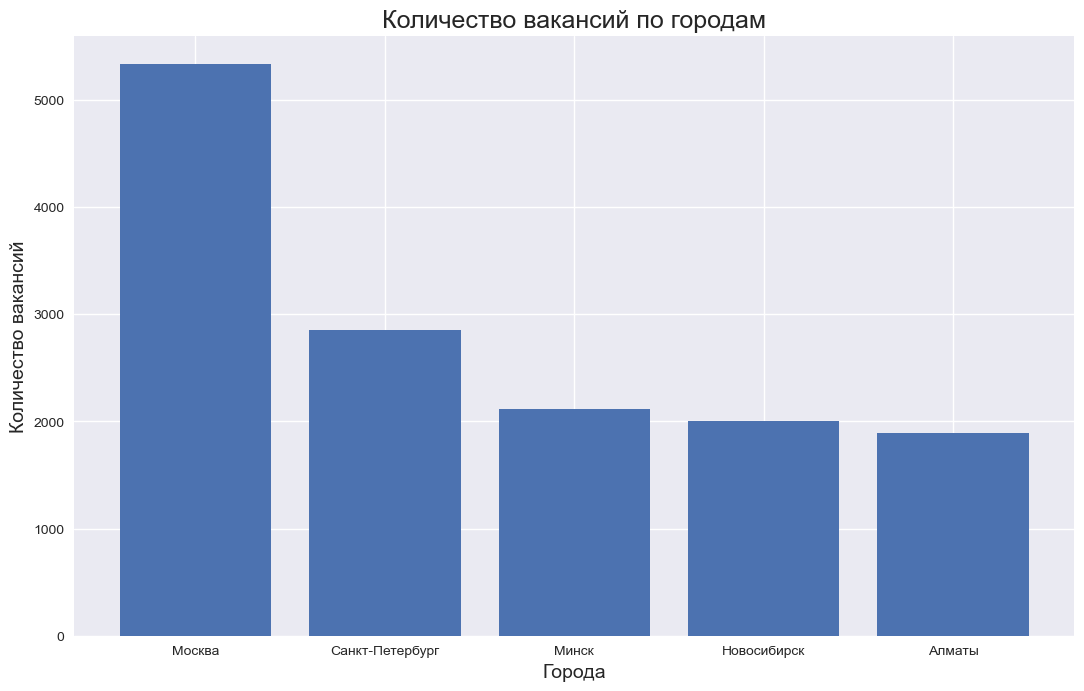

In [63]:
# визуализируем результат

fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])

axes.bar(x=vac_by_areaid_count.region_name, height = vac_by_areaid_count.vacancy_count);
axes.set_ylabel('Количество вакансий', fontsize=14)
axes.set_xlabel('Города', fontsize=14)
axes.set_title('Количество вакансий по городам', fontsize=18)
plt.show()

Определим, у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [64]:
# текст запроса
query_4_2 = f'''
            SELECT COUNT(id) AS vacancy_count
            FROM public.vacancies
            WHERE salary_from IS NOT Null OR salary_to IS NOT Null
'''

In [65]:
# результат запроса
not_null_salary_count = pd.read_sql_query(query_4_2, connection)
print(f'Количество вакансий с заполненными полями с зарплатой: {not_null_salary_count.vacancy_count[0]}')

Количество вакансий с заполненными полями с зарплатой: 24073


Найдём средние значения для нижней и верхней границы зарплатной вилки. Округлим значения до целого.

In [68]:
# текст запроса
query_4_3 = f'''
            SELECT ROUND(AVG(salary_from), 0) AS avg_min_salary, 
                   ROUND(AVG(salary_to), 0) AS avg_max_salary
            FROM public.vacancies
'''

In [69]:
# результат запроса
avg_salaryes = pd.read_sql_query(query_4_3, connection)
avg_salaryes
print(f'Среднее значение для нижней границы зарплатной вилки: {avg_salaryes.avg_min_salary[0]}')
print(f'Среднее значение для верхней границы зарплатной вилки: {avg_salaryes.avg_max_salary[0]}')

Среднее значение для нижней границы зарплатной вилки: 71065.0
Среднее значение для верхней границы зарплатной вилки: 110537.0


Выведем количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируем по убыванию количества.


In [73]:
# текст запроса
query_4_4 = f'''
            SELECT COUNT(id) AS vacancy_count, 
                   schedule, 
                   employment
            FROM public.vacancies
            GROUP BY schedule, employment
            ORDER BY vacancy_count DESC
            LIMIT 5
'''

In [74]:
# результат запроса
vacancy_count = pd.read_sql_query(query_4_4, connection)
vacancy_count

,vacancy_count,schedule,employment
0,35367,Полный день,Полная занятость
1,7802,Удаленная работа,Полная занятость
2,1593,Гибкий график,Полная занятость
3,1312,Удаленная работа,Частичная занятость
4,940,Сменный график,Полная занятость


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [21]:
# текст запроса
query_4_5 = f'''
            SELECT experience, 
                   COUNT(name) AS vacancy_count
            FROM public.vacancies
            GROUP BY experience
            ORDER BY vacancy_count ASC
'''

In [22]:
# результат запроса
experience_sorted = pd.read_sql_query(query_4_5, connection)
experience_sorted


,experience,vacancy_count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


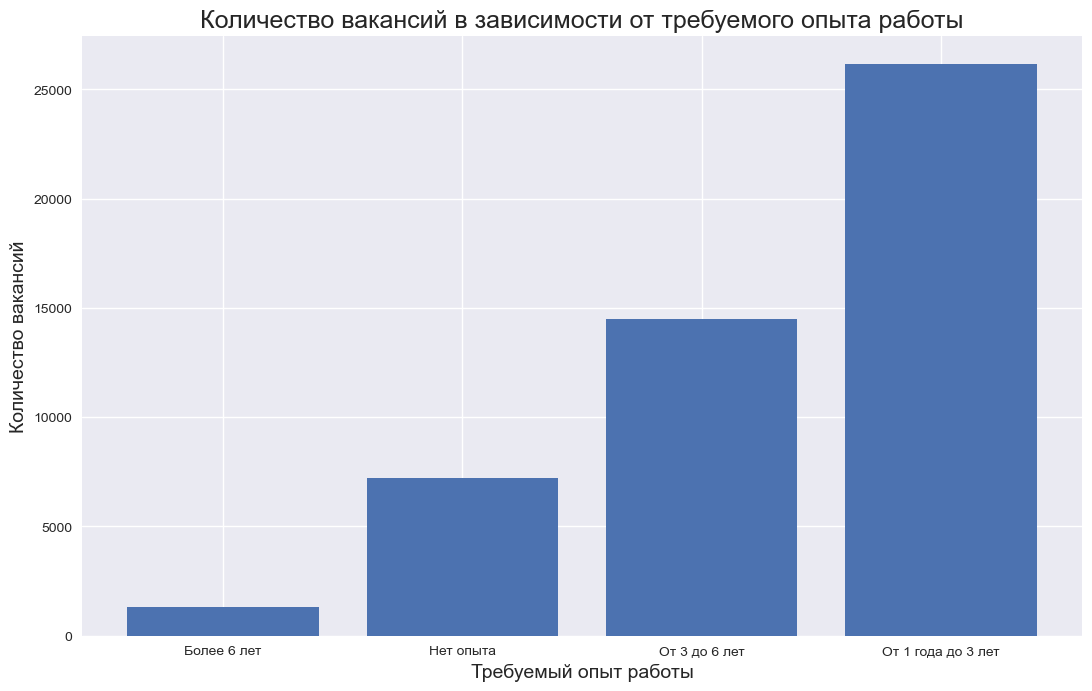

In [75]:
# визуализируем результат

fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])

axes.bar(x=experience_sorted.experience, height = experience_sorted.vacancy_count);
axes.set_ylabel('Количество вакансий', fontsize=14)
axes.set_xlabel('Требуемый опыт работы', fontsize=14)
axes.set_title('Количество вакансий в зависимости от требуемого опыта работы', fontsize=18)
plt.show()

***

### Выводы по детальному анализу вакансий

- Больше всего вакансий предлагается в таких городах, как: Москва, Санкт-Петербург, Минск, Новосибирск, Алматы. Причём, в Москве вакансий в два раза больше, чем в ближайшем к ней по числу вакансий Санкт-Петербурге.

- Данные о зарплате заполнены примерно у половины всех вакансий. 

- Средние значения нижней и верхней границ по зарплатам: 71065 и 110537

- Наиболее популярные сочетания типа рабочего графика и типа трудоустройства следующие: Полный день - Полная занятость, Удалённая работа - Полная занятость.

- Требования к опыту во всей совокупности изучаемых вакансий распределились так: больше всего вакансий требуют опыт от 1 до 3 лет, в два раза меньше вакансий с требованием к опыту от 3 до 6 лет, ещё в два раза меньше вакансий для соискателей без опыта работы, и лишь около 2.5% всех вакансий для соискателей с опытом более 6 лет.


## Анализ работодателей

Узнаем, какие работодатели предоставляют больше всего вакансий.

In [76]:
# текст запроса
query_5_1 = f'''
            SELECT emp.name AS emp_name,
                   COUNT(vac.name) AS vac_count
            FROM public.vacancies AS vac
            JOIN public.employers AS emp
            ON vac.employer_id=emp.id
            GROUP BY emp_name
            ORDER BY vac_count DESC
            LIMIT 5
'''

In [77]:
# результат запроса
emp_count_vac = pd.read_sql_query(query_5_1, connection)
emp_count_vac

,emp_name,vac_count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


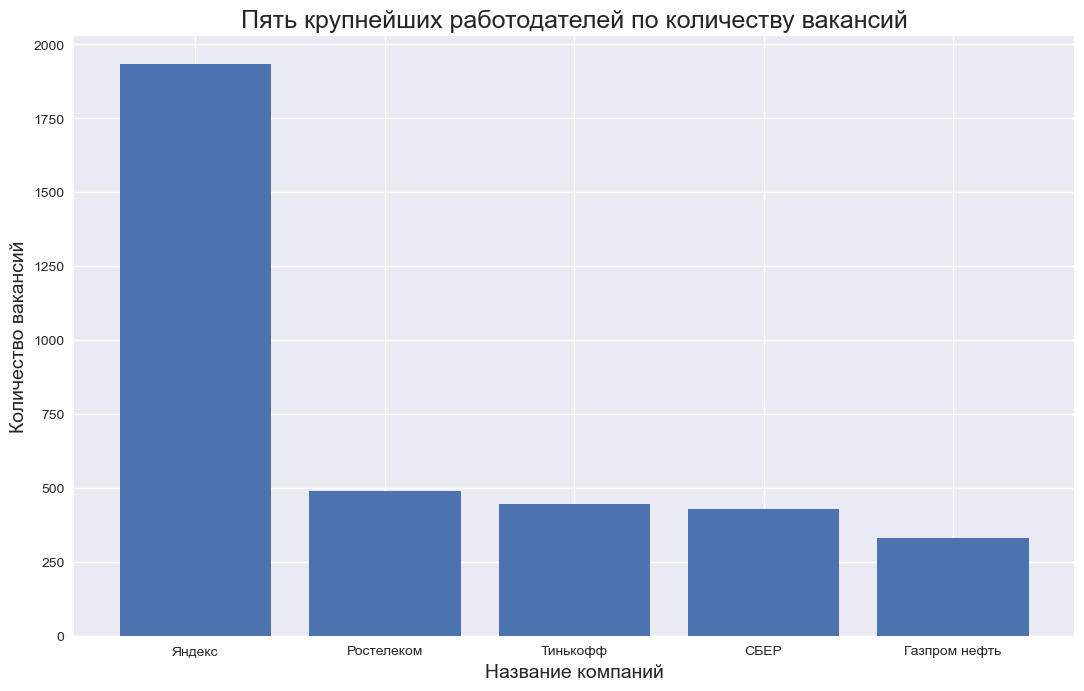

In [88]:
# визуализируем результат

fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])
labels = emp_count_vac.emp_name
sizes = emp_count_vac.vac_count

axes.bar(x=labels, height = sizes);
axes.set_ylabel('Количество вакансий', fontsize=14)
axes.set_xlabel('Название компаний', fontsize=14)
axes.set_title('Пять крупнейших работодателей по количеству вакансий', fontsize=18)
plt.show()

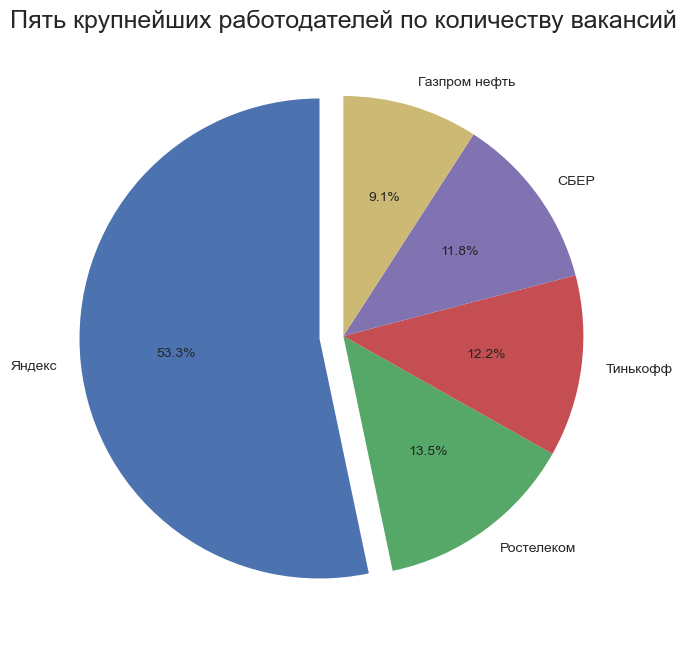

In [89]:
fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])

labels = emp_count_vac.emp_name
sizes = emp_count_vac.vac_count
explode = (0.1, 0, 0, 0, 0)

#plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90);
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90);
axes.set_title('Пять крупнейших работодателей по количеству вакансий', fontsize=18);

Определим запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдём тот, в котором наибольшее количество работодателей.


In [90]:
#запрос
query_5_2 = f'''
            SELECT ar.name AS region,
                   COUNT(DISTINCT(emp.name)) AS employer_count,
                   COUNT(DISTINCT(vac.name)) AS vacancies_count
            FROM public.areas AS ar
            LEFT JOIN public.vacancies AS vac
            ON ar.id=vac.area_id
            LEFT JOIN public.employers AS emp
            ON emp.area=ar.id
            WHERE vac.name IS Null
            
            GROUP BY region
            ORDER BY employer_count DESC
            LIMIT 5
                       
'''

In [91]:
# результат запроса
area_emp_vac_count = pd.read_sql_query(query_5_2, connection)
area_emp_vac_count

,region,employer_count,vacancies_count
0,Россия,410,0
1,Казахстан,207,0
2,Московская область,75,0
3,Краснодарский край,19,0
4,Беларусь,18,0


Для каждого работодателя посчитаем количество регионов, в которых он публикует свои вакансии. Отсортируем результат по убыванию количества.


In [92]:
query_5_3 = f'''
            SELECT emp.name AS emp_name,
                   COUNT(DISTINCT(vac.area_id)) AS area_count
            
            FROM public.vacancies AS vac
            LEFT JOIN public.employers AS emp
            ON vac.employer_id=emp.id
            GROUP BY emp.name
            ORDER BY area_count DESC
            LIMIT 5
'''

In [93]:
# результат запроса
employers = pd.read_sql_query(query_5_3, connection)
employers

,emp_name,area_count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71


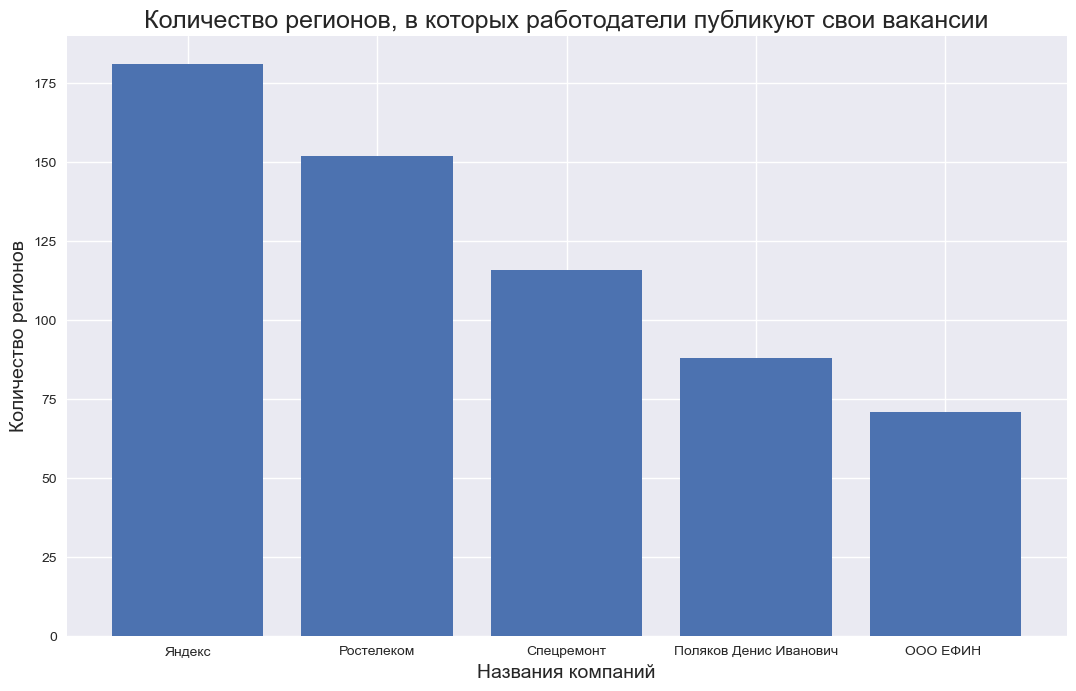

In [95]:
# визуализируем результат

fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])
names = employers.emp_name
counts = employers.area_count

axes.bar(x=names, height = counts);
axes.set_ylabel('Количество регионов', fontsize=14)
axes.set_xlabel('Названия компаний', fontsize=14)
axes.set_title('Количество регионов, в которых работодатели публикуют свои вакансии', fontsize=18)
plt.show()

Посчитаем количество работодателей, у которых не указана сфера деятельности. 


In [96]:
#Для этого сравним две таблицы: 
#- в таблице employers_industries может не быть записей о работодателях из таблицы employers.
#- поэтому объединим их с помощью left join (employers - левая таблица) и найдём строки, в которых industry_id имеет значение Null
#- посчитаем количество строк, соответствующих этому условию 

query_5_4 = f'''
            SELECT COUNT(*) AS emp_count
            FROM public.employers AS emp
            LEFT JOIN public.employers_industries AS emp_ind
            ON emp.id=emp_ind.employer_id
            WHERE industry_id IS Null
'''

In [97]:
# результат запроса
ind = pd.read_sql_query(query_5_4, connection)
ind
print(f'Число работодателей с неуказанной сферой деятельности: {ind.emp_count[0]}')

Число работодателей с неуказанной сферой деятельности: 8419


Узнаем название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [98]:
query_5_5 = f'''
            SELECT name,
                   COUNT(industry_id) AS ind_count
            FROM public.employers AS emp
            LEFT JOIN public.employers_industries AS emp_ind
            ON emp.id=emp_ind.employer_id
            GROUP BY name
            HAVING COUNT(industry_id) = 4
            ORDER BY name
            LIMIT 3
'''

In [99]:
# результат запроса
ind_4 = pd.read_sql_query(query_5_5, connection)
display(ind_4)
print()
print(f'Название третьей компании: {ind_4.name[2]}')


,name,ind_count
0,101 Интернет,4
1,21vek.by,4
2,2ГИС,4



Название третьей компании: 2ГИС


У какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [100]:
query_5_6 = f'''
            SELECT COUNT(*) developers_count
            FROM public.employers AS emp
            LEFT JOIN public.employers_industries AS emp_ind
            ON emp.id=emp_ind.employer_id
            LEFT JOIN public.industries AS ind
            ON emp_ind.industry_id=ind.id
            WHERE ind.name='Разработка программного обеспечения'
'''

In [101]:
# результат запроса
developers = pd.read_sql_query(query_5_6, connection)
print(f'Количество работодателей в области "Разработка программного обеспечения": {developers.developers_count[0]}')

Количество работодателей в области "Разработка программного обеспечения": 3553


Для компании «Яндекс» выведем список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. К данным добавим строку Total с общим количеством вакансий компании. Результат отсортируем по возрастанию количества.

Список городов-милионников возьмём [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 


In [103]:
#Получим кортеж с перечнем городов-миллионников
URL = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
response = requests.get(URL, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'})
page = BeautifulSoup(response.text, 'html.parser') 
links = page.find_all('a')
cities = tuple([link.text for link in links[916:932]]) #переведём в кортеж для обработки в SQL запросе
print(cities)

('Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Челябинск', 'Красноярск', 'Самара', 'Уфа', 'Ростов-на-Дону', 'Омск', 'Краснодар', 'Воронеж', 'Пермь', 'Волгоград')


In [104]:
# текст запроса
#cities = ('Москва','Санкт-Петербург','Новосибирск','Екатеринбург','Казань','Нижний Новгород',
#          'Челябинск','Красноярск','Самара','Уфа','Ростов-на-Дону','Омск','Краснодар','Воронеж','Пермь','Волгоград')

query_16 = f'''
            WITH emp_cities AS 
            (SELECT ar.name AS city,
                    COUNT(*) AS vacancy_count
            
            FROM public.vacancies AS vac
            LEFT JOIN public.employers AS emp
            ON emp.id=vac.employer_id
            LEFT JOIN public.areas AS ar
            ON ar.id=vac.area_id
            
            WHERE emp.name='Яндекс' AND ar.name IN {cities}
            
            GROUP BY ar.name
            ORDER BY vacancy_count ASC)
            
            --Создаём итоговую таблицу с суммой по колонке--
            
            SELECT * from emp_cities
            UNION ALL
            SELECT 'Total',
                    SUM(vacancy_count) 
            FROM emp_cities
'''

In [105]:
# результат запроса
cit = pd.read_sql_query(query_16, connection)
cit

,city,vacancy_count
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Пермь,25.0
5,Казань,25.0
6,Ростов-на-Дону,25.0
7,Уфа,26.0
8,Самара,26.0
9,Краснодар,30.0


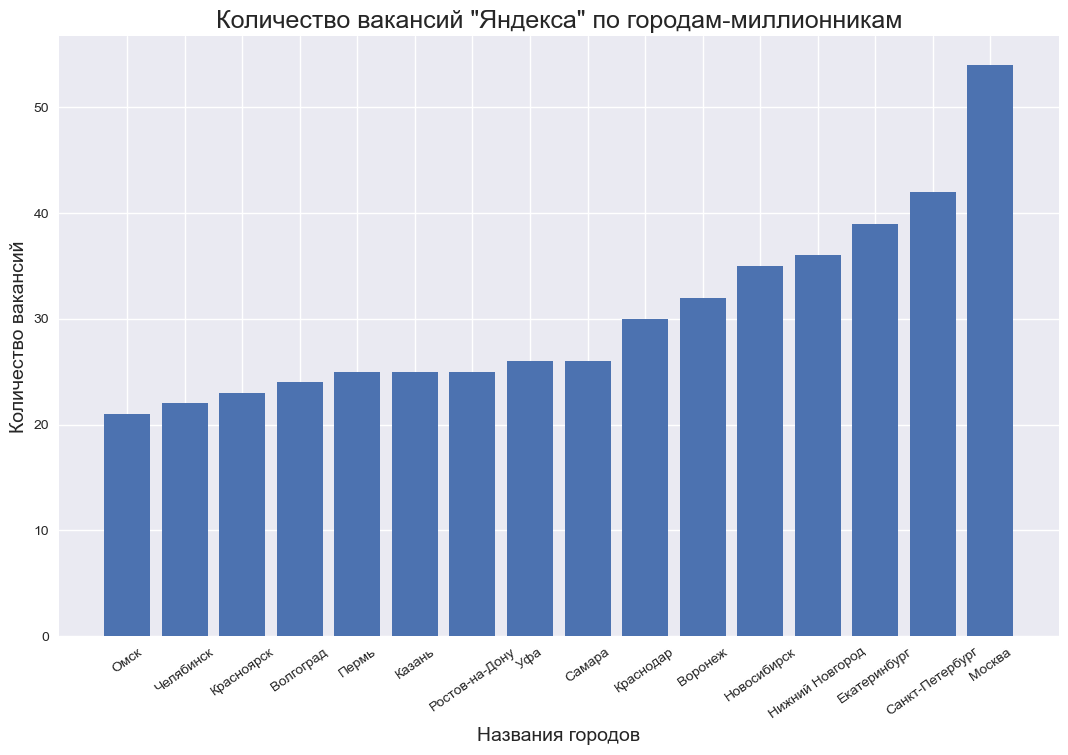

In [114]:
# визуализируем результат

fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])
names = cit.city.loc[:15]
counts = cit.vacancy_count.loc[:15]

axes.bar(x=names, height = counts);
axes.set_ylabel('Количество вакансий', fontsize=14)
axes.set_xlabel('Названия городов', fontsize=14)
axes.set_title('Количество вакансий "Яндекса" по городам-миллионникам', fontsize=18)
axes.tick_params(axis='x', labelrotation=35)
plt.show()

### Выводы по анализу работодателей

- Больше всего вакансий предлагают такие крупные компании как: Яндекс (лидирует с большим отрывом), Ростелеком, Тинькофф, СБЕР и Газпром нефть.

- Четверть всех вакансий компании Яндекс (485 вакансий) представлена в городах-миллионниках. Больше всего вакансий компании открыто в Москве и Санкт-Петербурге. Меньше всего вакансий компании в Омске, Челябинске и Красноярске.

- Вакансии по разработке программного обеспечения предлагает 3553 работодателя.

- Крупные компании, типа Яндекса, предлагают вакансии в большом количестве регионов (Яндекс в 181 регионе).

- Россия и Казахстан лидируют по числу компаний, в которых на данный момент нет открытых вакансий. 410 и 207 компаний соответственно.


## Предметный анализ

Оценим, сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Учтём, что названия вакансий могут быть написаны в любом регистре.* 


In [115]:
# текст запроса
query_6_1 = f'''
                SELECT name
                FROM public.vacancies
                WHERE lower(name) LIKE '%data%' OR lower(name) LIKE '%данн%'              
'''

In [116]:
# результат запроса
vac_data = pd.read_sql_query(query_6_1, connection)
print('Пример отфильтрованных вакансий:')
display(vac_data.head(5))
print()
print(f'Количество вакансий, связанных с данными: {vac_data.shape[0]}')

Пример отфильтрованных вакансий:


,name
0,Аналитик хранилищ данных и BI-систем/Аналитик ...
1,Data-analysts (удаленно)
2,Стажер Data Engineer/Data Аналитик в команду Б...
3,Старший специалист хранилищ данных
4,Администратор баз данных и сетей



Количество вакансий, связанных с данными: 1771


Узнаем, сколько есть подходящих вакансий для начинающего дата-сайентиста.
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих задачах мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [117]:
# текст запроса
query_6_2 = f'''
                WITH data_vacs AS(
                SELECT * 
                FROM public.vacancies
                WHERE 
                     lower(name) LIKE '%data scientist%' OR
                     lower(name) LIKE '%исследователь данных%' OR 
                     lower(name) SIMILAR TO '%[/| ]ml%' OR 
                     lower(name) SIMILAR TO '%[(]ml%' OR
                     lower(name) LIKE 'ml%' OR 
                     lower(name) LIKE '%machine learning%' OR
                     lower(name) LIKE '%машинн%обучен%'
                )
                
                SELECT *
                FROM data_vacs
                WHERE
                     lower(name) LIKE '%junior%' OR
                     experience = 'Нет опыта' OR
                     employment = 'Стажировка'
'''

In [118]:
# результат запроса
data_vacs = pd.read_sql_query(query_6_2, connection)
print(f'Количество вакансий, связанных с данными для джуниоров: {data_vacs.shape[0]}')


Количество вакансий, связанных с данными для джуниоров: 51


Оценим, сколько есть вакансий для датасайентистов, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [119]:
# текст запроса
query_6_3 = f'''
                WITH data_vacs AS(
                SELECT * 
                FROM public.vacancies
                WHERE 
                     lower(name) LIKE '%data scientist%' OR
                     lower(name) LIKE '%исследователь данных%' OR 
                     lower(name) SIMILAR TO '%[/| ]ml%' OR 
                     lower(name) SIMILAR TO '%[(]ml%' OR
                     lower(name) LIKE 'ml%' OR 
                     lower(name) LIKE '%machine learning%' OR
                     lower(name) LIKE '%машинн%обучен%'
                )
                
                SELECT *
                FROM data_vacs
                WHERE
                     lower(key_skills) LIKE '%sql%' OR
                     lower(key_skills) LIKE '%postgres%'
'''


In [120]:
# результат запроса
sql_ds_vacs = pd.read_sql_query(query_6_3, connection)
print(f'Количество вакансий, связанных с SQL и postgres: {sql_ds_vacs.shape[0]}')


Количество вакансий, связанных с SQL и postgres: 182


Проверим, насколько популярен Python в требованиях работодателей в вакансиях по DS. Для этого вычислим количество вакансий, в которых в качестве ключевого навыка указан Python.

In [121]:
# текст запроса
query_6_4 = f'''
                WITH data_vacs AS(
                SELECT * 
                FROM public.vacancies
                WHERE 
                     lower(name) LIKE '%data scientist%' OR
                     lower(name) LIKE '%исследователь данных%' OR 
                     lower(name) SIMILAR TO '%[/| ]ml%' OR 
                     lower(name) SIMILAR TO '%[(]ml%' OR
                     lower(name) LIKE 'ml%' OR 
                     lower(name) LIKE '%machine learning%' OR
                     lower(name) LIKE '%машинн%обучен%'
                )
                
                SELECT *
                FROM data_vacs
                WHERE
                     lower(key_skills) LIKE '%python%'
'''

In [122]:
# результат запроса
python_ds_vacs = pd.read_sql_query(query_6_4, connection)
print(f'Количество вакансий, связанных с Python: {python_ds_vacs.shape[0]}')


Количество вакансий, связанных с Python: 325


Сколько ключевых навыков в среднем указывают в вакансиях для DS? Ответ округлим до двух знаков после точки-разделителя.


In [126]:
#В решении использована идея о замене символа табуляции '\t' пустым значением.
#После этого находится разница между длиной полной строки и длиной строки с убранными знаками табуляции.
#Таким образом получаем количество навыков минус 1. 

query_6_5 = f'''
                WITH data_vacs AS(
                SELECT * 
                FROM public.vacancies
                WHERE 
                     lower(name) LIKE '%data scientist%' OR
                     lower(name) LIKE '%исследователь данных%' OR 
                     lower(name) SIMILAR TO '%[/| ]ml%' OR 
                     lower(name) SIMILAR TO '%[(]ml%' OR
                     lower(name) LIKE 'ml%' OR 
                     lower(name) LIKE '%machine learning%' OR
                     lower(name) LIKE '%машинн%обучен%'
                )
                
                SELECT AVG(LENGTH(CAST(key_skills AS CHAR(255))) - LENGTH(CAST(REPLACE(key_skills, '\t', '') AS CHAR(255))) + 1) AS skills_average_number
                FROM data_vacs
                WHERE LENGTH(CAST(key_skills AS CHAR(255))) - LENGTH(CAST(REPLACE(key_skills, '\t', '') AS CHAR(255))) > 0

'''

In [127]:
# результат запроса
skills_ds_vacs = pd.read_sql_query(query_6_5, connection)
print(f'Среднее число навыков в вакансиях Data Science: {round(skills_ds_vacs.skills_average_number[0], 2)}')

Среднее число навыков в вакансиях Data Science: 6.32


Вычислим, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примем во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null. Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясним, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлим до целого числа. 

In [128]:
query_6_6 = f'''
                WITH data_vacs AS(
                SELECT * 
                FROM public.vacancies
                WHERE 
                     lower(name) LIKE '%data scientist%' OR
                     lower(name) LIKE '%исследователь данных%' OR 
                     lower(name) SIMILAR TO '%[/| ]ml%' OR 
                     lower(name) SIMILAR TO '%[(]ml%' OR
                     lower(name) LIKE 'ml%' OR 
                     lower(name) LIKE '%machine learning%' OR
                     lower(name) LIKE '%машинн%обучен%'
                ),
                
                average_salary AS(
                SELECT experience,
                       salary_from,
                       salary_to,
                       CASE WHEN salary_from IS NOT Null AND salary_to IS NOT Null THEN (salary_from + salary_to)/2
                            WHEN salary_from IS Null AND salary_to IS NOT Null THEN salary_to
                            WHEN salary_from IS NOT Null AND salary_to IS Null THEN salary_from 
                       END AS salary
                FROM data_vacs
                WHERE salary_from IS NOT Null OR salary_to IS NOT Null
                )
                
                SELECT experience,
                       AVG(salary) AS avg_salary
                FROM average_salary
                GROUP BY experience
'''

In [129]:
# результат запроса
sal = pd.read_sql_query(query_6_6, connection)
print(f'Средняя зарплата для датасайентиста с опытом работы от 3 до 6 лет: {round(sal.avg_salary[0])}')


Средняя зарплата для датасайентиста с опытом работы от 3 до 6 лет: 240927


###  Выводы по предметному анализу

- Общее количество вакансий, связанных с данными: 1771 (из них только 426 напрямую относятся к Data Science).

- Количество вакансий в области Data Science для джуниоров: 51 из 426.

- Количество вакансий в области Data Science, связанных с SQL и postgres: 182 из 426.

- Количество вакансий в области Data Science, связанных с Python: 325 из 426.

- Среднее число навыков в вакансиях в области Data Science: 6.32. Интересно изучить, какие это навыки.

- Средняя зарплата для датасайентиста с опытом работы от 3 до 6 лет составляет 240927 рублей в месяц.

## Общий вывод по проекту

### Общие сведения

Данные включают 5 таблиц: vacancies, employers, areas, employers_industries, industries.

Общее количество вакансий в таблице vacancies - 49197

Общее количество работотаделей в таблице employers - 23501

Количество регионов, представленных в таблице areas - 1362

Количество сфер деятельности, представленных в таблице industries - 294


### Работодатели

Больше всего вакансий предлагают такие крупные компании как: Яндекс (лидирует с большим отрывом), Ростелеком, Тинькофф, СБЕР и Газпром нефть.

Четверть всех вакансий компании Яндекс (485 вакансий) представлена в городах-миллионниках. Больше всего вакансий компании открыто в Москве и Санкт-Петербурге. Меньше всего вакансий компании в Омске, Челябинске и Красноярске.

- компания Яндекс очень активно ищет сотрудников в провинции

Вакансии по разработке программного обеспечения предлагает 3553 работодателя.

- только 15% работодателей относятся к сфере разработки софта

Крупные компании, типа Яндекса, предлагают вакансии в большом количестве регионов (Яндекс в 181 регионе).

Россия и Казахстан лидируют по числу компаний, в которых на данный момент нет открытых вакансий. 410 и 207 компаний соответственно.

- вполне возможно, по этим данным можно косвенно судить о насыщении рынка вакансий в определённых сферах деятельности


### Вакансии

Больше всего вакансий предлагается в таких городах, как: Москва, Санкт-Петербург, Минск, Новосибирск, Алматы. Причём, в Москве вакансий в два раза больше, чем в ближайшем к ней по числу вакансий Санкт-Петербурге. (Вполне логичная картина).

Данные о зарплате заполнены примерно у половины всех вакансий.

- по этой причине судить о зарплатах в некоторых сферах деятельности достаточно проблематично. Нужны дополнительные источники информации.

Средние значения нижней и верхней границ по зарплатам: 71065 и 110537 

- интересно сравнить зарплаты в области Data Science с общей статистикой по зарплатам.

Наиболее популярные сочетания типа рабочего графика и типа трудоустройства следующие: Полный день - Полная занятость, Удалённая работа - Полная занятость.

Требования к опыту во всей совокупности изучаемых вакансий распределились так: 

- в большинстве вакансий требуется опыт от 1 до 3 лет (проще всего найти работу людям с опытом от 1 года)
- в два раза меньше вакансий с требованием к опыту от 3 до 6 лет
- ещё в два раза меньше вакансий для соискателей без опыта работы (найти работу без опыта достаточно трудно) 
- и лишь около 2.5% всех вакансий для соискателей с опытом более 6 лет

### Вакансии в области Data Science

Общее количество вакансий, связанных с данными: 1771 из почти 50000 (из них только 426 напрямую относятся к Data Science).

- только 3.5% вакансий связаны с работой с данными
- и лишь около 1% вакансий относятся к области Data Science

Количество вакансий в области Data Science для джуниоров: 51 из 426.

- 12% вакансий в области Data Science - для начинающих специалистов.

Количество вакансий в области Data Science, связанных с SQL и postgres: 182 из 426.

- 43% вакансий в области Data Science требуют знания SQL или PostgreSQL.

Количество вакансий в области Data Science, связанных с Python: 325 из 426.

- 76% вакансий в области Data Science требуют знания языка программирования Python.

Среднее число навыков в вакансиях в области Data Science: 6.32. Интересно изучить, какие это навыки.

- Вакансии в области Data Science требуют довольно много навыков - более 6 в среднем. Какие это навыки - требует отдельного изучения.

Средняя зарплата для датасайентиста с опытом работы от 3 до 6 лет составляет 240927 рублей в месяц.

## Дополнительные исследования (запланировано)

Имеет смысл провести дополнительные исследования для ответа на вопросы:

- В каких регионах больше всего компаний, разрабатывающих программное обеспечение?

- Какие компании охватывают максимальное количество сфер деятельности? 

- Какие навыки в области Data Science наиболее востребованы?

- Какой набор навыков ценится наиболее высоко в области Data Science?

- В каких регионах больше всего вакансий в области работы с данными?

- В каких регионах самые высокие зарплаты у специалистов по данным? Интересно сравнить зарплаты в области Data Science с общей статистикой по зарплатам.

- Отдельного изучения требует распределение разных вакансий во времени. К сожалению, наши данные не дают такой информации. 